# A/B Test

## Project Description

We've received an analytical task from an international online store. The predecessor failed to complete it: they launched an A/B test and then quit. They left only the technical specifications and the test results.

## Technical description

* Test name: recommender_system_test
* Groups: А (control), B (new payment funnel)
* Launch date: 2020-12-07
* The date when they stopped taking up new users: 2020-12-21
* End date: 2021-01-01
* Audience: 15% of the new users from the EU region
* Purpose of the test: testing changes related to the introduction of an improved recommendation system
* Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), product card views (product_card) and purchases (purchase). At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% increase.
* Expected number of test participants: 6000

## Study Goals:

* Download and preprocess test data
* Determine whether the A/B test was performed correctly.
* Analyze the results.
* Provide insights and recommendations to the client.

## 1. Load files and analyze general information

In [29]:
# load libraries
import pandas as pd
import numpy as np
import datetime as dt
import math
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings("ignore")


In [30]:
# load files
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates = ['start_dt', 'finish_dt'])
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', parse_dates = ['first_date'])
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', parse_dates = ['event_dt'])
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')


In [31]:
files =  [marketing_events, new_users, events, participants]
for file in files:
    display(file.head())
    display(file.info())
    print("\n")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


None

## 2. Data preprocessing


 We had already y changed the data type for all date columns to datetime. We did that for marketing_events, new_users, and events tables. So, first, we will check for ducplicate rows in all tables

In [32]:
file.duplicated().sum()
for file in files:
    display(file.duplicated().sum())

0

0

0

0

There are no duplicate rows.  From the previous step, we can see that values are missing in the details column in the events table.

In [33]:
events.groupby('event_name')['details'].unique()


event_name
login                                 [nan]
product_cart                          [nan]
product_page                          [nan]
purchase        [99.99, 9.99, 4.99, 499.99]
Name: details, dtype: object

Other than 'purcharse', we don't have information for the other events. Nothing seems wrong.
Analyzing descriptive info for 'new users' and 'events':


In [34]:
# Verify application dates
print("Earliest event date:", events['event_dt'].min())
print("Latest event date:", events['event_dt'].max())


Earliest event date: 2020-12-07 00:00:33
Latest event date: 2020-12-30 23:36:33


There are new users later than the specified date of 2020-12-21, up to 2020-12-23. We can see that the last event date is 2020-12-30, compared to the specified date - 2021-01-01. Now let's check the events within those dates:

In [36]:
# Filter events within the specified date range
events = events[(events['event_dt'] >= '2020-12-07') & (events['event_dt'] <= '2021-01-01')]


There's two tests. Since we need to study 'interface_eu_test', we'll drop the drop participants of the 'recommender_system_test'

In [37]:
participants = participants[participants['ab_test'] == 'interface_eu_test']
participants = participants.drop(columns=['ab_test'])
participants

,user_id,group
3675,D4E530F6595A05A3,A
3676,6BCB0F33D3BAB8C2,A
3677,FB6F6BC119E1DBD5,B
3678,2D2E7AA539CF348F,B
3679,4BA448BCE1343C6F,A
...,...,...
14520,1D302F8688B91781,B
14521,3DE51B726983B657,A
14522,F501F79D332BE86C,A
14523,63FBE257B05F2245,A


The test requires a 15% participation of new users from the EU region. Let's verify we indeed comply with that number:

In [38]:

new_users_eu = new_users[new_users['region'] == 'EU']
eu_participants = new_users_eu[new_users_eu['user_id'].isin(participants['user_id'])]

# Calculate the proportion of unique user_ids in the intersection to the unique user_ids in new_users_eu
proportion = eu_participants['user_id'].nunique() / new_users_eu['user_id'].nunique()

proportion


0.2500230435984883

25% of the new users from EU region are participants, while 15% is required in the description, so we can continue with the data.Verifying if we have  common users in both groups as well as the amount of participants for each group:

In [39]:
grouped = participants.groupby('user_id')['group'].nunique()

#Filter users who are in more than one group
filtered = grouped[grouped > 1].shape[0]
filtered

0

In [40]:
group_counts = participants.groupby('group').size()
group_counts

group
A    5467
B    5383
dtype: int64

There are no users assigned to both groups. We have similar number of participants in both group, and in total much more than the 6000 required. Now We'll merge the dataframes to one:

In [41]:
final_df = events.merge (participants, on = 'user_id', how = 'inner')
final_df = final_df.merge(new_users, on='user_id', how='inner')
display(final_df.head())
final_df.shape

,user_id,event_dt,event_name,details,group,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,B,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,B,2020-12-07,EU,iPhone


(78929, 8)

In [42]:
final_df.groupby('group')['user_id'].nunique()

group
A    5467
B    5383
Name: user_id, dtype: int64

**Filtering Relevant Events and Considering the First 14 Days**

In [43]:
# Filter relevant events for analysis
relevant_events = ['login', 'product_page', 'product_cart', 'purchase']
final_df = final_df[final_df['event_name'].isin(relevant_events)]

# Calculate the end date for each user (first 14 days since registration)
final_df['end_date'] = final_df['first_date'] + pd.Timedelta(days=14)

# Filter events to consider only the first 14 days since users registered
final_df = final_df[final_df['event_dt'] <= final_df['end_date']]

# Drop the 'end_date' column as it's no longer needed
final_df = final_df.drop(columns=['end_date'])
final_df.head(10)

,user_id,event_dt,event_name,details,group,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,B,2020-12-07,EU,iPhone
5,96F27A054B191457,2020-12-08 09:43:18,product_page,NaN,B,2020-12-07,EU,iPhone
6,96F27A054B191457,2020-12-09 00:44:10,product_page,NaN,B,2020-12-07,EU,iPhone
8,96F27A054B191457,2020-12-07 04:02:40,login,NaN,B,2020-12-07,EU,iPhone
9,96F27A054B191457,2020-12-08 09:43:14,login,NaN,B,2020-12-07,EU,iPhone
10,96F27A054B191457,2020-12-09 00:44:10,login,NaN,B,2020-12-07,EU,iPhone
12,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,2020-12-07,EU,Android


## 3. Exploratory Data Analysis (EDA)

Checking the logs to see which events occurred and how often they occurred

In [44]:
final_df['event_name'].value_counts()

login           32438
product_page    21336
purchase        11148
product_cart    10660
Name: event_name, dtype: int64

Let's calculate  the number of unique users who performed each event and the proportion of these users relative to the total number of unique users.

From the technical description, the event funnel is login > product page > product_cart > purchase. 

In [45]:


def create_funnel_data(df, group=None):
    if group:
        df = df[df['group'] == group]
    funnel_data = df.groupby('event_name')['user_id'].nunique().reset_index()
    funnel_data.columns = ['events', 'users']
    total_users = df['user_id'].nunique()
    funnel_data['share_%'] = (funnel_data['users'] / total_users * 100).round(2)
    
    # Ensure the events are in the desired order
    event_order = ['login', 'product_page', 'product_cart', 'purchase']
    funnel_data['event_order'] = funnel_data['events'].apply(lambda x: event_order.index(x))
    funnel_data = funnel_data.sort_values('event_order').drop(columns='event_order').reset_index(drop=True)
    
    return funnel_data


# Create funnel data for all groups
events_funnel = create_funnel_data(final_df)

# Create funnel data for group A
events_funnel_a = create_funnel_data(final_df, group='A')

# Create funnel data for group B
events_funnel_b = create_funnel_data(final_df, group='B')

# Display the funnel data for group A and B to verify
display(events_funnel)
display(events_funnel_a) 
display(events_funnel_b)

# Plot the funnel for both groups
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Group A',
    y=events_funnel_a['events'],
    x=events_funnel_a['users'], 
    textinfo="value+percent initial"))
fig.add_trace(go.Funnel(
    name='Group B',
    y=events_funnel_b['events'],
    x=events_funnel_b['users'], 
    textinfo="value+percent initial"))

fig.update_layout(title='Sales funnel for experimental groups')
fig.show()


,events,users,share_%
0,login,10847,99.99
1,product_page,7164,66.04
2,product_cart,3568,32.89
3,purchase,3713,34.23


,events,users,share_%
0,login,5465,99.98
1,product_page,3638,66.56
2,product_cart,1756,32.13
3,purchase,1931,35.33


,events,users,share_%
0,login,5382,100.00
1,product_page,3526,65.51
2,product_cart,1812,33.67
3,purchase,1782,33.11


Initial Engagement (Login to Product Page):

Both groups have similar conversion rates from login to product page view (Group A: 67%, Group B: 66%). This suggests that the initial engagement strategies are similarly effective across both groups.
Adding to Cart (Product Page to Product Cart):

Group A has a slightly lower conversion rate (32%) compared to Group B (34%). This might indicate that users in Group B find the products or the user interface more compelling to add items to the cart.
Completing Purchase (Product Cart to Purchase):

Group A shows a higher conversion rate (35%) compared to Group B (33%). This suggests that once users in Group A add items to their cart, they are slightly more likely to complete the purchase than users in Group B. This could be due to better checkout processes, incentives, or fewer obstacles in the purchase flow for Group A.

**Is the number of events per user distributed equally in the samples?**

In [46]:
# Group by 'group' and calculate the number of unique users and total events
events_group_per_user = final_df.groupby('group').agg(
    num_users=('user_id', 'nunique'), 
    total_events=('event_dt', 'count')
).reset_index()

# Calculate the average number of events per user
events_group_per_user['average_events_per_user'] = events_group_per_user['total_events'] / events_group_per_user['num_users']


events_group_per_user

,group,num_users,total_events,average_events_per_user
0,A,5466,38386,7.022686
1,B,5382,37196,6.911185


Let's check the relative frequency of each event within each group:

In [47]:
# Group by 'group' and count the value occurrences of 'event_name', normalize to get proportions
event_group = final_df.groupby('group')['event_name'].value_counts(normalize=True).reset_index(name='share')
event_group['share'] = (event_group['share'] * 100).round(2)

event_group

,group,event_name,share
0,A,login,42.74
1,A,product_page,28.33
2,A,purchase,15.15
3,A,product_cart,13.77
4,B,login,43.10
5,B,product_page,28.13
6,B,product_cart,14.45
7,B,purchase,14.33


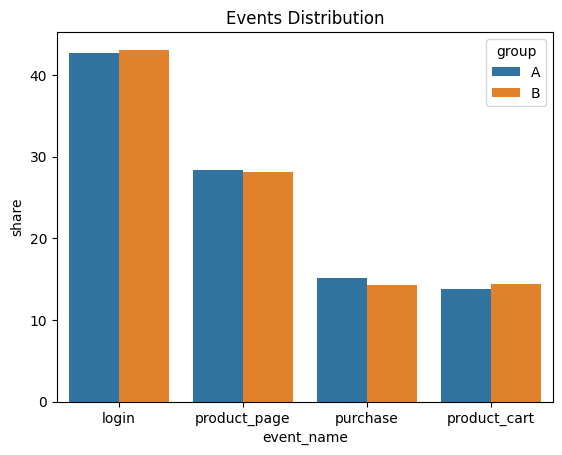

In [48]:
ax = sns.barplot(x="event_name", y="share", hue="group", data=event_group).set_title("Events Distribution")
plt.show()

We can confirm that the number of events per user distributed equally in the samples. Now we will check for users who have been assigned to multiple groups in an A/B test,  count the number of users who are present in exactly one group within 'final_df'

**Are there users included in both samples?** 

In [49]:
final_df.groupby(["user_id"])["group"].nunique().reset_index().query("group>1").shape[0]

0

**How is the number of events distributed by days?**

In [50]:
final_df.groupby(["user_id"])["group"].nunique().reset_index().query("group==1").shape[0]

10848

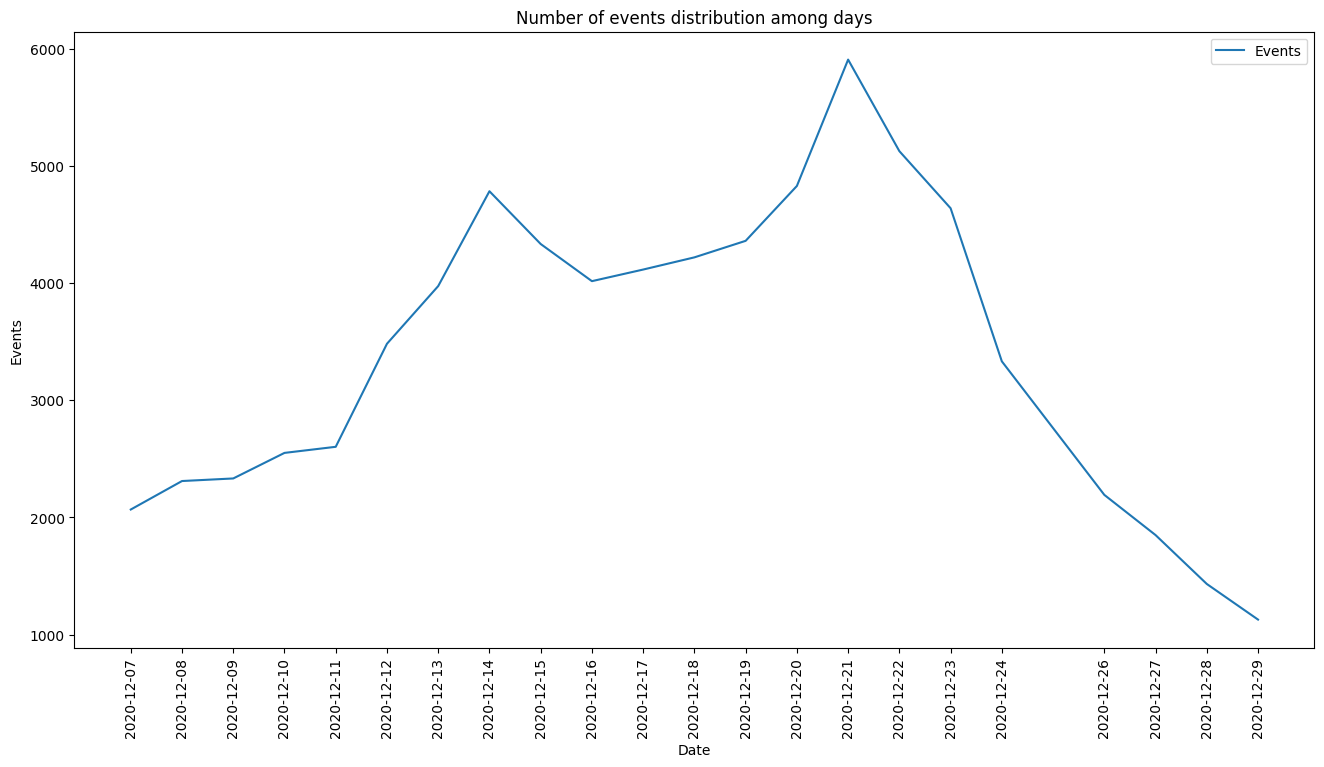

In [51]:
final_df['event_date']= final_df['event_dt'].dt.date
days = final_df.groupby(['event_date']).agg({'user_id':'nunique', 'event_dt':'count'}).reset_index()

plt.figure(figsize=(16,8))
plt.title('Number of events distribution among days')
sns.lineplot(data=days, x='event_date', y='event_dt', label='Events')
plt.xlabel('Date')
plt.xticks(days.event_date, rotation=90)
plt.ylabel('Events')
plt.show()

The chart displays the distribution of the number of events from December 7, 2020, to December 30, 2020, revealing a clear pattern in user activity. Initially, there is a noticeable increase in the number of events, starting at around 2,000 on December 7 and steadily rising to approximately 4,000 by December 13. This early growth suggests increased user engagement or activities during the first week. The trend continues upward, reaching its peak on December 22 with nearly 6,000 events. This peak, a significant spike in user activity leading up to the holidays, is a standard period for increased online transactions and interactions as users engage more with the app for holiday shopping or end-of-year activities.

Following the peak on December 22, there is a noticeable decline in the number of events, dropping to around 4,000 by December 26 and continuing to decrease towards the end of the month. This post-peak decline could be attributed to the holiday season, during which users may be less engaged with the app due to holiday celebrations and vacation periods. By December 30, the number of events falls sharply to around 1,000, suggesting the end of a promotional period, seasonal activities, or a natural decrease in user engagement following the holiday peak. These insights highlight the impact of seasonal trends and holiday periods on user engagement and activity within the page.

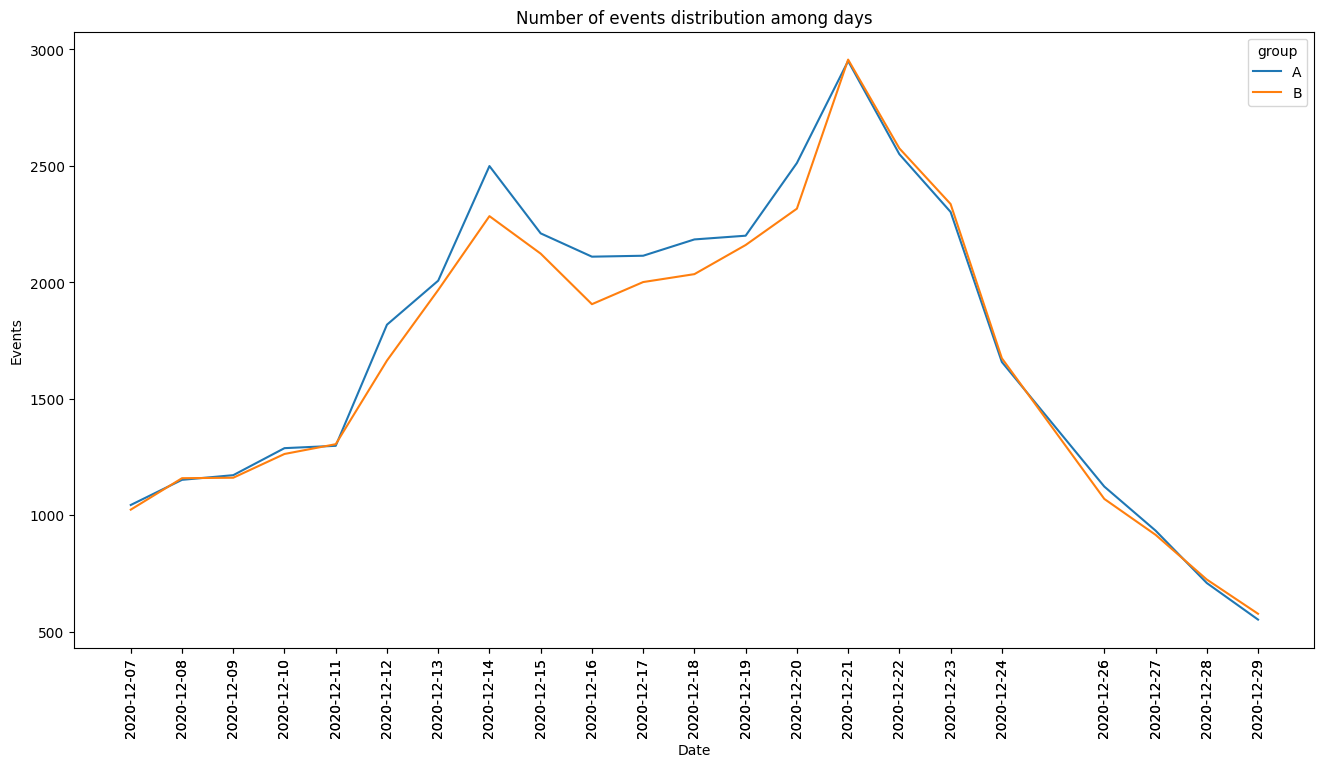

In [52]:
final_df[['event_date']] = final_df['event_dt'].dt.date
days = final_df.groupby(['event_date', 'group']).agg({'user_id':'nunique', 'event_dt':'count'}).reset_index()
plt.figure(figsize=(16,8))
plt.title('Number of events distribution among days')
sns.lineplot(data=days, x='event_date', y='event_dt', hue="group")
plt.xlabel('Date')
plt.xticks(days.event_date, rotation=90)
plt.ylabel('Events')
plt.show()

Regarding the distribution of the number of events from December 7, 2020, to December 30, 2020, for both Group A and Group B, both groups follow a similar trend, starting with around 1,000 events on December 7 and showing a steady increase in user activity. The number of events rises sharply around December 13, with Group A and Group B peaking around December 22-23. This peak period shows nearly 3,000 events for each group, indicating heightened user engagement and activity leading to the holidays.

Post-peak, both groups experience a noticeable decline in the number of events. The decline begins immediately after December 23, with events decreasing to around 1,500 by December 26 and continuing to drop towards the end of the month. By December 30, the number of events falls below 1,000 for both groups. The parallel trends observed in Group A and Group B suggest that external factors, such as holiday celebrations and vacation periods, equally affect user engagement across both experimental groups. The consistency in the pattern highlights similar user behavior and engagement levels during the observed period, reflecting the impact of seasonal trends on usage.

## 4. Evaluate the A/B test results

**What can you tell about the A/A test results?**

In [53]:
alpha = 0.5 / 5
pvalue = proportions_ztest(
    final_df.query('group == "A"')['user_id'].nunique(), 
    final_df['user_id'].nunique(), value = 0.50)[1]

print('\np-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Fail to reject H0: there is not significant difference between groups')
else:
    print('Reject H0: there is a statistically significant difference between the groups.')


p-value: 0.4199405903028445
Fail to reject H0: there is not significant difference between groups


**Use the z-criterion to check the statistical difference between the proportions**

In [54]:
# Create a pivot table to summarize unique user counts for each event by group
pivot = final_df.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').reset_index()

# Calculate the conversion percentages for groups A and B
pivot['conversion_%_A'] = ((pivot['A'] / final_df[final_df['group'] == 'A']['user_id'].nunique()) * 100).round(2)
pivot['conversion_%_B'] = ((pivot['B'] / final_df[final_df['group'] == 'B']['user_id'].nunique()) * 100).round(2)

pivot

group,event_name,A,B,conversion_%_A,conversion_%_B
0,login,5465,5382,99.98,100.00
1,product_cart,1756,1812,32.13,33.67
2,product_page,3638,3526,66.56,65.51
3,purchase,1931,1782,35.33,33.11


We establish the hypothesis:

**H0:** There is no statistically significant difference between the groups.

**H1:** There is a statistically significant difference between the groups.

alpha = 0.05

In [55]:
def check_hypothesis(group1, group2, event, alpha):
    # Extract the number of users who performed the event in each group
    successes1 = pivot[pivot['event_name'] == event][group1].iloc[0]
    successes2 = pivot[pivot['event_name'] == event][group2].iloc[0]
    
    # Extract the total number of unique users in each group
    trials1 = final_df[final_df['group'] == group1]['user_id'].nunique()
    trials2 = final_df[final_df['group'] == group2]['user_id'].nunique()
    
    # Calculate the proportions of users who performed the event in each group
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    # Calculate the combined proportion for both groups
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # Calculate the difference between the two proportions
    difference = p1 - p2
    
    # Calculate the z-value for the difference in proportions
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    
    # Get the cumulative distribution function of the standard normal distribution
    distr = st.norm(0, 1)
    
    # Calculate the two-tailed p-value from the z-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
 # Print the z-value, p-value, and the conclusion of the hypothesis test
    print(f'Event: {event}, z-value: {z_value}, p-value: {p_value}')
    if p_value < alpha:
        print(f'Reject H0 for {event} between groups {group1} and {group2}')
        print(f'The z-score for {event} is {z_value}. Since the p-value is less than {alpha}, we reject the null hypothesis. This indicates that there is a statistically significant difference between groups {group1} and {group2} for the {event} event.')
    else:
        print(f'Fail to reject H0 for {event} between groups {group1} and {group2}')
        print(f'The z-score for {event} is {z_value}. Since the p-value is greater than {alpha}, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between groups {group1} and {group2} for the {event} event.')


In [56]:
# Loop through each event and test the hypothesis
for event in pivot['event_name'].unique():
    check_hypothesis('A', 'B', event, 0.05)

Event: login, z-value: -0.9923321252714674, p-value: 0.32103553711445576
Fail to reject H0 for login between groups A and B
The z-score for login is -0.9923321252714674. Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between groups A and B for the login event.
Event: product_cart, z-value: -1.7090828304346526, p-value: 0.08743560749822121
Fail to reject H0 for product_cart between groups A and B
The z-score for product_cart is -1.7090828304346526. Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between groups A and B for the product_cart event.
Event: product_page, z-value: 1.1460477926942088, p-value: 0.2517753775039957
Fail to reject H0 for product_page between groups A and B
The z-score for product_page is 1.1460477926942088. Since the p-value is greater than 0.05, we fail to reject th

While the changes do not significantly affect earlier stages such as logging in, viewing product pages, or adding items to the cart, they have a meaningful impact on the purchase completion rate. It's the only he only event with statistically significant difference between the samples.

However, since we carried out 4 statistical hypothesis tests with statistical significance level of 0.05., the probability of making at least one Type I error (false positive) increases when making comparisons with the same data.  We'll use the Bonferroni procedure to adjust the significance level (alpaha) to account for the number os tests being perfomed. We are performing 4 tests and want to maintain an overall significance level of 0.05, the Bonferroni correction sets the significance level for each individual test to 0.05/4=0.0125

In [57]:
bonferroni_alpha = 0.05 / 4
for event in pivot['event_name'].unique():
    check_hypothesis('A', 'B', event, bonferroni_alpha)


Event: login, z-value: -0.9923321252714674, p-value: 0.32103553711445576
Fail to reject H0 for login between groups A and B
The z-score for login is -0.9923321252714674. Since the p-value is greater than 0.0125, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between groups A and B for the login event.
Event: product_cart, z-value: -1.7090828304346526, p-value: 0.08743560749822121
Fail to reject H0 for product_cart between groups A and B
The z-score for product_cart is -1.7090828304346526. Since the p-value is greater than 0.0125, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between groups A and B for the product_cart event.
Event: product_page, z-value: 1.1460477926942088, p-value: 0.2517753775039957
Fail to reject H0 for product_page between groups A and B
The z-score for product_page is 1.1460477926942088. Since the p-value is greater than 0.0125, we fail to rej

After applying the Bonferroni correction, we no longer find a statistically significant difference for the purchase event between Groups A and B. This indicates that the initial finding of a significant difference might have been a false positive due to multiple comparisons.

## 5. Conclusions


**Study Goals:**

* Download and preprocess test data
* Determine whether the A/B test was performed correctly.
* Analyze the results.
* Provide insights and recommendations to the client.

**Evaluation of A/B Test Execution:**

Upon reviewing the data, we identified several issues indicating that the A/B test was not carried out exactly as specified in the technical description:

   **Inconsistent User Registration Dates:**
    New users registered up to December 23, 2020, which is beyond the specified end date of December 21, 2020.

   **Event Dates Discrepancy:** 
     The last recorded event date was December 30, 2020, rather than the specified completion date of January 1, 2021.

   **Irrelevant Test Data:** 
     Data from another unrelated test, 'recommender_system_test,' was included, potentially affecting the analysis.

**Exploratory Data Analysis (EDA) Findings:** 

    Funnel Analysis:

    * Login to Product Page: 66.1% of users who logged in proceeded to view the product page.
    * Product Page to Purchase: 51.8% of users who viewed the product page made a purchase.
    * Overall Conversion: 34.22% of users completed the journey from login to purchase.
    * Add to Cart: 32.88% of users added products to their cart instead of purchasing directly.

**Event Distribution:**

* Average Events per User: Users had an average of 7.3 events each.
* Event Distribution Equality: The number of events per user was equally distributed across the samples.
* Temporal Distribution: Significant spikes in event activity were observed on Mondays, December 14 and 21. This pattern suggests heightened activity as users prepared for Christmas, followed by a sharp decline after December 24 (Christmas Eve).


**A/B Test Results:**

**Statistically Significant Differences:**

The only event with a statistically significant difference between Group A and Group B was the 'purchase' event.
Conversion Rates: Group A had a higher purchase conversion rate than Group B, indicating the new system could have performed better.

**Recommendation:**


Based on the findings from the A/B test, I recommend discontinuing the current test and reverting to the previous recommendation system. The new system could have delivered improved results and demonstrated better conversion rates. Reinstating the old system will be more advantageous for maintaining user engagement and optimizing purchase conversions.
